# Milestone 4: Analysis and Visualisation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

### Import transformed loans paymentment data that's been cleaned in the previous milestone:

In [2]:
df = pd.read_csv('/Users/hollymorris/Python/exploratory-data-analysis---customer-loans-in-finance994/transformed_loans_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51986 entries, 0 to 51985
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          51986 non-null  int64  
 1   member_id                   51986 non-null  int64  
 2   loan_amount                 51986 non-null  int64  
 3   funded_amount               51986 non-null  float64
 4   funded_amount_inv           51986 non-null  float64
 5   term                        51986 non-null  object 
 6   int_rate                    51986 non-null  float64
 7   instalment                  51986 non-null  float64
 8   grade                       51986 non-null  object 
 9   sub_grade                   51986 non-null  object 
 10  employment_length           51986 non-null  object 
 11  home_ownership              51986 non-null  object 
 12  annual_inc                  51986 non-null  float64
 13  verification_status         519

## Current state of the loans:

While performing the analysis in this milestone it can be helpful to have the data dictionary on hand to get an overview of what each column represents: data_dictionary.md

We will query the data to check the current state of the payments:

Summarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.

Additionally calculate how much will be paid back in 6 months time with interest. Visualise your results on an appropriate graph.

In [3]:
# Convert interest rate to decimal form
df['decimal_int_rate'] = df['int_rate'] / 100

# Sum of recovered payments across all loans
amount_recovered = df['total_payment'].sum()

# Apply interest rate per loan and add to loan amount for total to be paid per loan
df['interest_to_be_paid'] = df['loan_amount'] * df['decimal_int_rate']
df['total_to_be_paid'] = df['interest_to_be_paid'] + df['loan_amount']

# Sum total to be paid of all loans 
total_to_be_paid = df['total_to_be_paid'].sum()

# Calculate percentage of loans currently recovered
percentage_recovered = (amount_recovered / total_to_be_paid) * 100

print(f'Percentage of loans that have currently been recovered {percentage_recovered:.2f}%')
print(f'Total amount to be paid over loans term £{total_to_be_paid:.2f}')
print(f'Total amount of loans recovered to date £{amount_recovered:.2f}')

Percentage of loans that have currently been recovered 79.68%
Total amount to be paid over loans term £796587684.03
Total amount of loans recovered to date £634744506.97


In [4]:
# Calculate loans to be paid back in 6 months' time 
payments_over_next_6_mths = df['instalment'] * 6
total_over_next_6_mths = payments_over_next_6_mths.sum()

print(f'Total amount that will be paid back in 6 months time £{total_over_next_6_mths:.2f}')

Total amount that will be paid back in 6 months time £125642277.54


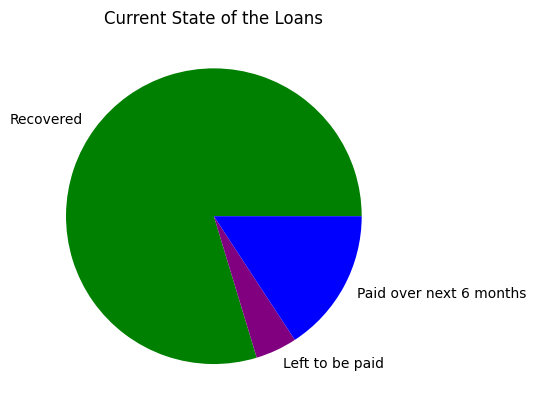

In [5]:
# Calculate percentages for pie chart 
percentage_paid_6_mths = (total_over_next_6_mths/total_to_be_paid) * 100
percentage_left_to_be_paid = 100 - (percentage_recovered + percentage_paid_6_mths)

# Data for pie chart 
labels = ['Recovered', 'Left to be paid', 'Paid over next 6 months']
percentages = [percentage_recovered, percentage_left_to_be_paid, percentage_paid_6_mths]
colors = ['green', 'purple', 'blue']

# Plot pie chart
plt.figure
plt.pie(percentages, labels=labels, colors=colors)
plt.title('Current State of the Loans')
plt.show()

## Calculating loss:

The company wants to check what percentage of loans have been a loss to the company:

Loans marked as Charged Off in the loan_status column represent a loss to the company.

Calculate the percentage of charged off loans and the total amount that was paid towards these loans before being charged off.

In [6]:
# Filter loans with status 'Charged Off'
charged_off_loans = df[df['loan_status'] == 'Charged Off'] 

# Count number of Charged Off loans in DataFrame
number_charged_off_loans = len(charged_off_loans)

# Count total number of rows(loans) in DataFrame
number_all_loans = len(df)

# Calculate percentage of Charged Off loans 
percentage_charged_off_loans = (number_charged_off_loans/number_all_loans) * 100

print(f'Percentage of charged off loans: {percentage_charged_off_loans:.2f}%')

Percentage of charged off loans: 10.06%


In [7]:
# Calculate the total amount paid towards these loans
total_paid_towards_charged_off_loans = charged_off_loans['total_payment'].sum()

print(f'Total amount that was paid towards Charged Off loans before being charged off: £{total_paid_towards_charged_off_loans:.2f}')

Total amount that was paid towards Charged Off loans before being charged off: £35893274.67


## Calculating projected loss:


Calculate the expected loss of the loans marked as Charged Off.

Calculate the loss in revenue these loans would have generated for the company if they had finished their term. Visualise the loss projected over the remaining term of these loans.

In [8]:
# Calulate how much of Charged Off loans not paid back 
df['loan_left_unpaid'] = df['loan_amount']  - df['total_payment']
loss_of_loans = df.loc[df['loan_status'] == 'Charged Off', 'loan_left_unpaid'].sum()

print(f'Expected loss of loans marked as Charged Off: £{loss_of_loans:.2f}')

Expected loss of loans marked as Charged Off: £36982725.33


In [12]:
# Calculate revenue for Charged Off loans
df['loan_revenue'] = df['total_to_be_paid'] - df['total_payment']
charged_off_revenue_loss = df.loc[df['loan_status'] == 'Charged Off', 'loan_revenue'].sum()

print(f'Loss in revenue these loans would have generated if terms had finished: £{charged_off_revenue_loss:.2f}')

Loss in revenue these loans would have generated if terms finished: £48573186.75


In [ ]:
# Convert issue_date and last_payment_date to datetime
def transform_dates(df):
    date_columns = [
        'issue_date',
        'last_payment_date'
        ]
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
    return df

transform_dates(df)

# Convert term to int
df['term'] = df['term'].str.extract(r'(\d+)').astype(int)

In [ ]:
# Filter loans for Charged Off from transformed dataframe 
charged_off_loans = df[df['loan_status'] == 'Charged Off'] 

In [ ]:
# Calculate loan's term paid to date
df['months_paid_to_date'] = (df['last_payment_date'] - df['issue_date']).dt.days // 30
charged_off_months_paid = df.loc[df['loan_status'] == 'Charged Off', 'months_paid_to_date']

# Calculate remaining term of loan
df['months_left'] = df['term'] - df['months_paid_to_date']
charged_off_months_left = df.loc[df['loan_status'] == 'Charged Off', 'months_left']

monthly_loss = charged_off_revenue_loss / charged_off_months_left

# Plot loss projected over remaining terms of loans 

## Possible loss:

There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.

What percentage do users in this bracket currently represent?

Calculate the total amount of customers in this bracket and how much loss the company would incur if their status was changed to Charged Off.

What is the projected loss of these loans if the customer were to finish the full loan term?

If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

In [13]:
# Check all loans have unique customer 
total_loans = len(df)
total_customers = len(df['member_id'].unique())
print(total_loans)
print(total_customers)

# Filter loans where loan_status contains string 'Late'
late_loans = df[df['loan_status'].str.contains("Late")]

# Count of how many loans are late
total_customers_late = len(late_loans)

# Calculate percentage of late loans compared to all loans
percentage_late_loans = (total_customers_late / len(df)) * 100

print(f'Percentage of members behind with their loan payments: {percentage_late_loans:.2f}%')
print(f'Total amount of customers currently behind on their loan payments: {total_customers_late}')

51986
51986
Percentage of members behind with their loan payments: 1.24%
Total amount of customers currently behind on their loan payments: 647


In [27]:
# Calulate loss if Late loans not paid back 
df['loan_left_unpaid'] = df['loan_amount']  - df['total_payment']
loss_of_late_loans = df.loc[df['loan_status'].str.contains("Late"), 'loan_left_unpaid'].sum()

print(f'Expected loss of loans if customers behind on payments were switched to Charged Off: £{loss_of_late_loans:.2f}')

Expected loss of loans if customers behind on payments were switched to Charged Off: £3246977.74


In [25]:
# Calculate projected loss for Late loans
df['loan_revenue'] = df['total_to_be_paid'] - df['total_payment']
late_revenue_loss = df.loc[df['loan_status'].str.contains("Late"), 'loan_revenue'].sum()

print(f'Loss in revenue these loans would have generated if terms had finished: £{late_revenue_loss:.2f}')

Loss in revenue these loans would have generated if terms had finished: £4872098.03


In [28]:
total_expected_revenue = total_to_be_paid - amount_recovered

total_expected_revenue_loss = charged_off_revenue_loss + late_revenue_loss

percentage_expected_revenue_loss = (total_expected_revenue_loss/total_expected_revenue) * 100

print(f'Percentage: {percentage_expected_revenue_loss:.2f}%')


Percentage: 33.02%


## Indicators of loss:

In this task, you will be analysing the data to visualise the possible indicators that a customer will not be able to pay the loan.

You will want to compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

Here are some example columns that might indicate that a user might not pay the loan:
Does the grade of the loan have an effect on customers not paying?
Is the purpose for the loan likely to have an effect?
Does the home_ownership value contribute to the likelihood a customer won't pay?
To help identify which columns will be of interest, first create a subset of these users.

Make the analysis and determine the columns are contributing to loans not being paid off and visualise any interesting indicators.
Compare these indicators between loans already charged off and loans that could change to charged off to check if these same factors apply to loans that have the potential to change to "Charged Off".

In [31]:
# Create subset of customers with Charged Off and Late 
charged_off_and_late_df = pd.concat([
    df[df['loan_status'] == 'Charged Off'],
    df[df['loan_status'].str.contains("Late")]
    ])

0.11306890316623706


In [ ]:
calculate percentage of each category instead of count 

In [18]:
df['grade'].value_counts()

grade
B    15669
C    13042
A     9380
D     7815
E     3928
F     1647
G      505
Name: count, dtype: int64

In [32]:
charged_off_and_late_df['grade'].value_counts()

grade
C    1566
B    1367
D    1270
E     764
A     413
F     382
G     116
Name: count, dtype: int64

In [19]:
df['purpose'].value_counts()

purpose
debt_consolidation    28479
credit_card           10619
other                  3504
home_improvement       3045
major_purchase         1610
small_business         1279
car                     991
medical                 602
wedding                 525
moving                  433
house                   337
vacation                298
educational             191
renewable_energy         73
Name: count, dtype: int64

In [33]:
charged_off_and_late_df['purpose'].value_counts()

purpose
debt_consolidation    3323
credit_card            942
other                  481
small_business         296
home_improvement       288
major_purchase         167
car                     92
medical                 79
moving                  62
house                   40
vacation                37
wedding                 36
educational             24
renewable_energy        11
Name: count, dtype: int64

In [20]:
df['home_ownership'].value_counts()


home_ownership
MORTGAGE    25872
RENT        21674
OWN          4376
OTHER          63
NONE            1
Name: count, dtype: int64

In [34]:
charged_off_and_late_df['home_ownership'].value_counts()

home_ownership
RENT        2735
MORTGAGE    2608
OWN          526
OTHER          9
Name: count, dtype: int64

In [ ]:
barchart (x axis = categories for indicator columns)
legend(customers charged off, late customers and other customers)

 def visualise_nulls_removal(self, df, transformed_df):
        null_percentage_before = df.isna().mean() * 100
        null_percentage_after = transformed_df.isna().mean() * 100

        null_comparison = pd.DataFrame({
            'Before Transformation': null_percentage_before,
            'After Transformation': null_percentage_after
        }).fillna(0)
        fig, axes = plt.subplots(1,2, figsize=(20, 3))

        sns.barplot(null_percentage_before, ax=axes[0])
        axes[0].set_ylabel('Percentage')
        axes[0].set_xlabel('Columns')

        null_comparison.plot(kind='bar')
        fig.suptitle('Percentage of Null Values Before and After Transformation')
        plt.show()